In [34]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from qutip import *
import matplotlib.gridspec as gridspec
from scipy.integrate import trapezoid
from qutip import wigner

In [ ]:
N = 10

cat_state = (coherent(N,alpha=1) - coherent(N,alpha=-1))

sq = squeeze(N, z = np.log(1.2))

cat_state_squeezed = (sq * cat_state).unit()

x = np.linspace(-5, 5, 100)

p = np.linspace(-5, 5, 100)

cat_W = wigner(cat_state_squeezed, x, p)

# vi behøves ikke at have density matrices fordi vi har ikke losses med endnu, så derfor kan cat bare være en ket state.

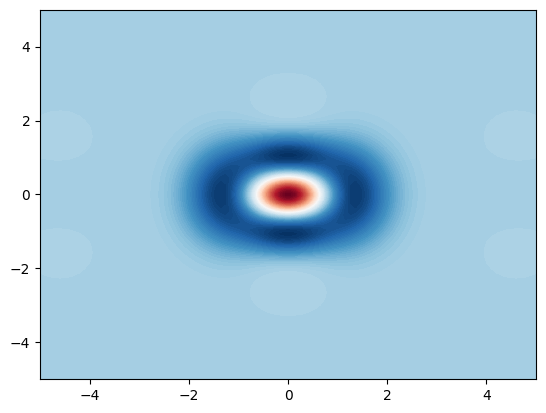

In [36]:
plt.contourf(x, p, cat_W, 100, cmap='RdBu')

In [39]:
def BS_operator_func(eta,N1, N2):
    ## Create a beam splitter operator with angle theta

    a1 = destroy(N1)
    a1dag = a1.dag()
    a2 = destroy(N2)
    a2dag = a2.dag()

    theta = np.arccos(np.sqrt(1/eta))

    x1 = (a1 + a1dag)*1/np.sqrt(2)
    p1 = 1j * (a1dag - a1)*1/np.sqrt(2)
    x2 = (a2 + a2dag)*1/np.sqrt(2)
    p2 = 1j * (a2dag - a2)*1/np.sqrt(2)

    BS = 1j * theta * (tensor(p1, x2) - tensor(x1, p2))

    return BS.expm()


def density_matrix(state):
    """Compute the density matrix of a quantum state."""
    return state * state.dag()

cat_DM = density_matrix(cat_state_squeezed)


$|OUT\rangle = BS(\theta) |CAT\rangle_{1} \otimes |CAT\rangle_{2}$

FIRST BS

In [40]:
BS_operator_eta2 = BS_operator_func(2, N, N) 

tensor_cat = tensor(cat_DM, cat_DM)

cat_out01 = (BS_operator_eta2 * tensor_cat * BS_operator_eta2.dag()).unit()

cat_0 = ptrace(cat_out01, 0) 
cat_1 = ptrace(cat_out01, 1)

W_cat_0 = wigner(cat_0, x, p)
W_cat_1 = wigner(cat_1, x, p)

W_cat01 = wigner(cat_out01, x, p)

SECOND BS

In [ ]:
BS_operator_eta3 = BS_operator_func(3, N, N) 

tensor_cat2 = tensor(cat_1, cat_DM)

cat_out12 = (BS_operator_eta3 * tensor_cat2 * BS_operator_eta3.dag()).unit()

cat_1 = ptrace(cat_out12, 0)
cat_2 = ptrace(cat_out12, 1)

W_cat12 = wigner(cat_out12, x, p)

tensor_cat3 = tensor(cat_2, cat_DM)

BS_operator_eta4 = BS_operator_func(4, N, N) 

cat_out23 = (BS_operator_eta4 * tensor_cat3 * BS_operator_eta4.dag()).unit()

cat_2 = ptrace(cat_out23, 0)
cat_3 = ptrace(cat_out23, 1)

W_cat23 = wigner(cat_out23, x, p)

BS_operator_eta5 = BS_operator_func(5, N, N)

tensor_cat4 = tensor(cat_3, cat_DM)

cat_out34 = (BS_operator_eta5 * tensor_cat4 * BS_operator_eta5.dag()).unit()

cat_3 = ptrace(cat_out34, 0)
print(cat_3)
cat_4 = ptrace(cat_out34, 1)

W_cat34 = wigner(cat_out34, x, p)


Quantum object: dims=[[10], [10]], shape=(10, 10), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 2.82658932e-01  0.00000000e+00  1.23233419e-02  0.00000000e+00
  -8.87860314e-03  0.00000000e+00 -6.06125850e-04  0.00000000e+00
   9.10526506e-05  0.00000000e+00]
 [ 0.00000000e+00  4.74242352e-01  0.00000000e+00  7.12716903e-02
   0.00000000e+00 -3.87826733e-04  0.00000000e+00 -4.26927477e-04
   0.00000000e+00 -2.76191276e-05]
 [ 1.23233419e-02  0.00000000e+00  1.70281821e-01  0.00000000e+00
   3.73642645e-02  0.00000000e+00  7.23040010e-04  0.00000000e+00
  -1.72463307e-04  0.00000000e+00]
 [ 0.00000000e+00  7.12716903e-02  0.00000000e+00  5.13029224e-02
   0.00000000e+00  1.19282449e-02  0.00000000e+00  1.42657860e-04
   0.00000000e+00 -8.89666176e-05]
 [-8.87860314e-03  0.00000000e+00  3.73642645e-02  0.00000000e+00
   1.56328790e-02  0.00000000e+00  2.64010979e-03  0.00000000e+00
  -5.31632619e-05  0.00000000e+00]
 [ 0.00000000e+00 -3.87826733e-04  0.00000000e+00  1.19282449e-0

In [ ]:
cat_3

Quantum object: dims=[[10], [10]], shape=(10, 10), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 2.82658932e-01  0.00000000e+00  1.23233419e-02  0.00000000e+00
  -8.87860314e-03  0.00000000e+00 -6.06125850e-04  0.00000000e+00
   9.10526506e-05  0.00000000e+00]
 [ 0.00000000e+00  4.74242352e-01  0.00000000e+00  7.12716903e-02
   0.00000000e+00 -3.87826733e-04  0.00000000e+00 -4.26927477e-04
   0.00000000e+00 -2.76191276e-05]
 [ 1.23233419e-02  0.00000000e+00  1.70281821e-01  0.00000000e+00
   3.73642645e-02  0.00000000e+00  7.23040010e-04  0.00000000e+00
  -1.72463307e-04  0.00000000e+00]
 [ 0.00000000e+00  7.12716903e-02  0.00000000e+00  5.13029224e-02
   0.00000000e+00  1.19282449e-02  0.00000000e+00  1.42657860e-04
   0.00000000e+00 -8.89666176e-05]
 [-8.87860314e-03  0.00000000e+00  3.73642645e-02  0.00000000e+00
   1.56328790e-02  0.00000000e+00  2.64010979e-03  0.00000000e+00
  -5.31632619e-05  0.00000000e+00]
 [ 0.00000000e+00 -3.87826733e-04  0.00000000e+00  1.19282449e-0

In [ ]:
def BS_cascade(eta_list, N, cat_state):
    """Create a list of beam splitter operators for a cascade of beam splitters."""
    BS_list,cat_DM_out_list, cat_mode_list_0, cat_mode_list_1 = [],[],[],[]

    tensor_cat_start = tensor(cat_state, cat_state)
    tensor_cat = tensor_cat_start

    for eta in eta_list:
        BS = BS_operator_func(eta, N, N)
        BS_list.append(BS)

        cat_DM_out = (BS * tensor_cat * BS.dag()).unit()

        cat_DM_out_list.append(cat_DM_out)
        cat_mode_0 = ptrace(cat_DM_out, 0)
        cat_mode_1 = ptrace(cat_DM_out, 1)

        tensor_cat = tensor(cat_mode_1, cat_state)

        cat_mode_list_0.append(cat_mode_0) #mode to be measured
        #cat_mode_list_1.append(cat_mode_1) # continues to be Beamsplit

    cat_final_state = cat_mode_1

    return cat_mode_list_0, cat_final_state


    return BS_list


In [ ]:
eta_list = [2 ,3, 4, 5, 6]

cat_mode_list_0, cat_final_state = BS_cascade(eta_list, N, cat_DM)

In [ ]:
wigner = wigner(cat_final_state,x,p)

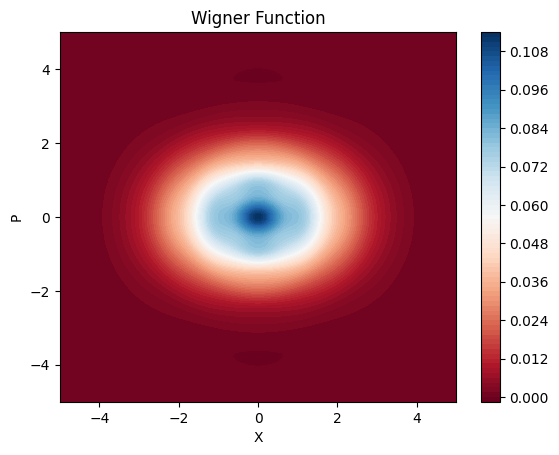

In [ ]:
plt.contourf(x, p, wigner, levels=100, cmap='RdBu')
plt.colorbar()
plt.title('Wigner Function')
plt.xlabel('X')
plt.ylabel('P')
plt.show()

# HOMODYNE MEASUREMENT

$P_{\theta}(x) = \langle \hat{x_{\theta}} | \hat{\rho}| \hat{x_{\theta}} \rangle$

In [ ]:
def homodyne_measurement(N, state, theta = np.pi/2):

    a = destroy(N)
    
    x_theta = (a * np.exp(-1j*theta) + a.dag() * np.exp(1j*theta)) / np.sqrt(2)

    e_vals, e_states = x_theta.eigenstates()

    P_p = np.array([ (e.dag() * state * e).real for e in e_states ])

    return P_p




In [ ]:
homodyne_measurements = []

for i in cat_mode_list_0:
    homodyne_measurements.append(homodyne_measurement(i))


TypeError: homodyne_measurement() missing 1 required positional argument: 'state'

In [ ]:
cat_1_homo = homodyne_measurement(N, cat_1)
cat_2_homo = homodyne_measurement(N, cat_2)
cat_3_homo = homodyne_measurement(N, cat_3)
cat_4_homo = homodyne_measurement(N, cat_4)

In [ ]:
cat_list_homo = [cat_1_homo, cat_2_homo, cat_3_homo, cat_4_homo]

Text(0.5, 1.0, 'homodyne measurement')

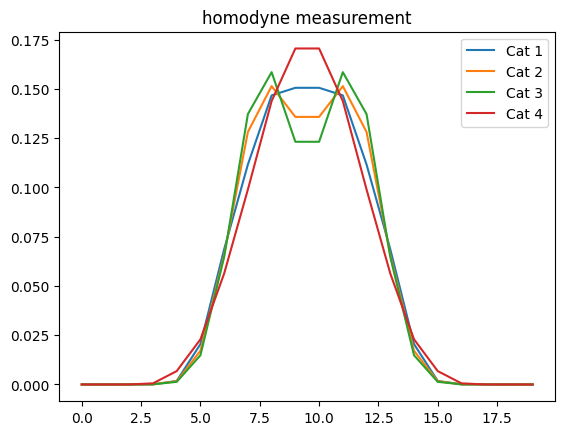

In [ ]:
for i in range(len(cat_list_homo)):
    plt.plot(cat_list_homo[i], label=f"Cat {i+1}")
plt.legend()
plt.title('homodyne measurement')


In [ ]:
# antag p altid vil måle P=0 , da der ellers vil komme displacements 
